# Determination of uncertainty in the description of crack widths using artificial neural networks

## Info

This notebook is created and originally uploaded on GitHub by Anton van der Esch and contains the calculations of the paper "Determination of uncertainty in the description of crack widths using artificial neural networks". Before using this notebook, please consider the accompanying license which can be found in the licence. If you have questions, please contact me by, see below the contact details.


Contact info:
<br>
-[antonvanderesch@hotmail.com](antonvanderesch@hotmail.com) or [i.a.v.d.esch@tue.nl](i.a.v.d.esch@tue.nl)
<br>
-PhD Candidate at Eindhoven University of Technology

## Introduction

This notebook provides the code for the paper "Determination of uncertainty in the description of crack widths using artifical neural networks". It has been divided into several parts: <br>
1) Import of packages <br>
2) Settings to plot figures <br>
3) Import dataset; remove certain measurements <br>
4) Calculation of crack widths according to EN1992-1-1 <br>
5) Exploratory Data Analysis (EDA) <br>
6) Settings ANN and LUBE <br>
7) Repeated K-fold Cross Validation <br>
8) Derive PIs, using LUBE technique <br>
9) Predict the mean <br>
10) Plotting <br>
11) Calculate MPIW, PICP

## 1 - Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
from keras import backend as K
import tensorflow as tf
from keras.optimizers import adam_v2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy.stats import lognorm
import seaborn as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import random
import os

In [2]:
Rseed = 42; # Seed to generate random numbers

## 2 - Figure settings

In [3]:
cm = 1/2.54;
figsize = [8*cm,8*cm];

plt.rcParams.update({'mathtext.fontset': 'cm'})
plt.rcParams.update({'font.family': 'STIXGeneral'})
plt.rcParams.update({'axes.labelsize': 10})
plt.rcParams.update({'axes.titlesize': 11})

import matplotlib.ticker as mticker
dpisize = 600;

## 3 - Import dataset, remove certain values

### Import dataset

The dataset consists of crack widths, collected from crack width measurements. The measurments are collected from the report "Rapport des essais. De Tirants sous déformation imposée de courte durée", from the authors Bicher Farra and Jean-Paul Jaccoud. The dataset contains of the following variables:
<br>
-No: sample number
<br>
-Source: authors of the document
<br>
-Name: name of the document where the crack widths has been collected
<br>
-$\rho$: reinforcement ratio [-] (in promille)
<br>
-$E_{\mathrm{s}}$: young's modulus of reinforcement steel [GPa]
<br>
-$f_{\mathrm{r}}$: influence of type of reinforcement steel [-]
<br>
-$c_{\mathrm{bot}}$: cover between reinforcement and bottom fiber [mm]
<br>
-$f_{\mathrm{cm}}$: average cylinderical compression strength [MPa]
<br>
-$f_{\mathrm{ctm}}$: average tensile strength [MPa]
<br>
-$E_{\mathrm{cm}}$: average young's modulus of concrete [GPa]
<br>
-$\sigma_{\mathrm{s}}$: steel stress in the reinforcement at the location of the crack [MPa]
<br>
-$\phi$: diameter of the reinforcement [mm]
<br>
-$w$: measured crack width [mm]

In [4]:
dfav = pd.read_csv('https://github.com/iavdesch/AI/blob/main/datasets/dataset_FiB_PhD_Symp.csv?raw=true',sep=',');

Steel stresses smaller than 50 MPa are removed.

In [5]:
dfav.drop(dfav[dfav['sigs'] < 50].index, inplace = True);

Crack widths smaller than 0.05 mm are removed.

In [6]:
dfav.drop(dfav[dfav['w'] < 0.05].index, inplace = True);

Split the dataset into test (20%) and training (80%) set.

In [7]:
trainav, testav = train_test_split(dfav,test_size=0.2,shuffle=True,random_state=Rseed);

The following variables are not relevant in the EDA (Exploratory Data Analysis).

In [8]:
trainav.drop(["Source","Name","ID","No","fr"],axis=1,inplace=True);
testav.drop(["Source","Name","ID","No","fr"],axis=1,inplace=True);

C:\Users\20210065\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
testav_org = testav.copy(); # Create a copy of the original test set
trainav_org = trainav.copy(); # Create a copy of the original training set

### Check for illegal/corrupt values

If no value is returned, the dataset does not contain corrupt  or illegal values.

In [10]:
# Check if there are NAN-values
dfav.isnull().values.any()
check_nan_in_df = dfav.isnull()

# Check which rows contain NAN-values
rows_with_nan = []
for index, row in dfav.iterrows():
    is_nan_series = row.isnull()
    if is_nan_series.any():
        rows_with_nan.append(index)

# Return the rows with NAN (if any)
print(rows_with_nan)

[]


### Summary of the dataset

Extract the number of test and training samples.

In [11]:
def printprop(train,test):
    print("Number of training samples:", train.shape[0])
    print("Number of test samples:", test.shape[0])
    print("Total number of samples:", train.shape[0]+test.shape[0])

In [12]:
printprop(trainav,testav);

Number of training samples: 521
Number of test samples: 131
Total number of samples: 652


## 4 - Computing crack widths according to EN1992-1-1

Calculation of crack widths according to EN1992-1-1, par. 7.3.4.

### Parameters

In [13]:
k_t = 0.6; # Assume short term loading
k1 = 0.8; # Assume high bond properties 
k2 = 1; # For pure tension loading
k3 = 3.4;
k4 = 0.425;

beta = 1.7; # Factor to convert characteristic into average crack width
h = 100; # Height of the specimen

In [14]:
def wec(dataset,k_t,k1,k2,k3,k4):
    sr_max = np.zeros(len(dataset));
    eps_diff = np.zeros(len(dataset));
    w_k = np.zeros(len(dataset));
    w_m = np.zeros(len(dataset));
    
    for i in range(len(dataset)):
        
        UPPER = np.maximum((50 - 0.8*(dataset["fcm"].values[i]-8))*dataset["phi"].values[i],15*dataset["phi"].values[i]);  
        
        sr_max[i] = np.minimum(k3*dataset["cbot"].values[i] + k1*k2*k4*dataset["phi"].values[i]/(dataset["rho"].values[i]/1000),\
                               UPPER);
    
        eps_diff[i] = np.maximum((dataset["sigs"].values[i] - k_t*(dataset["fctm"].values[i]/(dataset["rho"].values[i]/1000))* \
        ((1 + (dataset["Es"].values[i]/dataset["Ecm"].values[i])*(dataset["rho"].values[i]/1000)))) / \
                               (1000*dataset["Es"].values[i]), \
                         0.6*dataset["sigs"].values[i]/(1000*dataset["Es"].values[i]));
    
        w_k[i] = eps_diff[i]*sr_max[i];
        
        w_m[i] = w_k[i] / beta;
    
    return sr_max, eps_diff, w_k, w_m

In [15]:
w_kav = wec(testav,k_t,k1,k2,k3,k4)[2];
w_mav = wec(testav,k_t,k1,k2,k3,k4)[3];

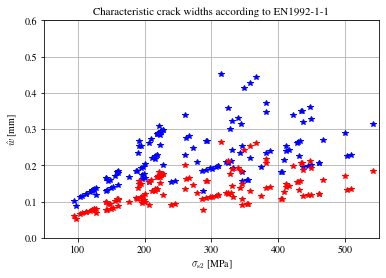

In [16]:
plt.figure();
plt.title("Characteristic crack widths according to EN1992-1-1")
plt.plot(testav["sigs"],w_kav,"*b",label="Characteristic crack widths according to EN1992-1-1");
plt.plot(testav["sigs"],w_mav,"*r",label="Average crack widths according to EN1992-1-1");
plt.xlabel(r"$\sigma_{\mathrm{s}2}$ [MPa]");
plt.ylabel("$\hat{w}$ [mm]");
plt.xlim([50,550]);
plt.ylim([0,0.6]);
plt.grid();

## 5 - Exploratory Data Analysis

Function "plotdistext" plots the distribution of a variable in the dataset.

In [17]:
def plotdistext(dataset,nbins,P5,P25,P50,P75,P95,var):
    # Plot normal distribution
    locn,scalen = norm.fit(dataset[var]);
    pdfn = norm.pdf(dataset[var],locn,scalen);

    # Plot lognormal distribution
    shapeln,locln,scaleln = lognorm.fit(dataset[var]);
    pdfln = lognorm.pdf(dataset[var],shapeln,locln,scaleln);
    
    plt.hist(dataset[var],bins=nbins,density=True,color="grey",alpha=0.5);
    plt.title("Distributions fitted on crack widths");
    plt.xlabel(r"$w$ [mm]");
    plt.ylabel("PDF");
    plt.plot(dataset[var],pdfln,"g*",label="Lognormal distribution");
    plt.plot(dataset[var],pdfn,"r*",label="Normal distribution");
    plt.legend();
    plt.grid();

Function "plotdist" prints the distribution of a variable in the dataset.

In [18]:
def plotdist(dataset,nbins,P5,P25,P50,P75,P95,var):
    plt.figure();
    plt.hist(dataset[var],bins=nbins);
    plt.title('Distribution of variable '+str(var));
    plt.xlabel(var);
    plt.ylabel("Frequency");
    plt.grid();

# Extracting the percentiles
    print("Percentiles of variable",var)
    print("5% - ",np.percentile(dataset[var],P5));
    print("25% - ",np.percentile(dataset[var],P25));
    print("50%, median - ",np.percentile(dataset[var],P50));
    print("75% - ",np.percentile(dataset[var],P75));
    print("95% - ",np.percentile(dataset[var],P95));
    print("============================");
    print("\n");

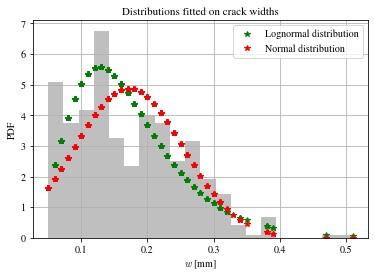

In [19]:
# Database with avarage crack widths
plotdistext(trainav,20,5,25,50,75,95,"w");

The graph presented above shows that the crack widths of the training set can be described by using a lognormal distrubtion ro normal distribution. The lognormal distribution reveals a better fit. Below, for several variables the 5%, 25%, 50%, 75% and 95% quatiles are computed.

Percentiles of variable rho
5% -  7.853981634
25% -  7.853981634
50%, median -  15.393804
75% -  31.41592654
95% -  31.41592654


Percentiles of variable Es
5% -  196.3166667
25% -  196.3166667
50%, median -  197.5
75% -  200.5333333
95% -  200.5333333


Percentiles of variable cbot
5% -  40.0
25% -  40.0
50%, median -  43.0
75% -  45.0
95% -  45.0


Percentiles of variable fcm
5% -  29.9
25% -  38.8
50%, median -  46.3
75% -  53.8
95% -  67.2


Percentiles of variable fctm
5% -  2.13
25% -  2.64
50%, median -  2.81
75% -  2.98
95% -  3.16


Percentiles of variable Ecm
5% -  27.5
25% -  30.7
50%, median -  32.5
75% -  35.9
95% -  41.83


Percentiles of variable sigs
5% -  111.0
25% -  178.0
50%, median -  255.0
75% -  363.0
95% -  465.0


Percentiles of variable rho
5% -  7.853981634
25% -  7.853981634
50%, median -  15.393804
75% -  31.41592654
95% -  31.41592654


Percentiles of variable w
5% -  0.06
25% -  0.11
50%, median -  0.16
75% -  0.23
95% -  0.31




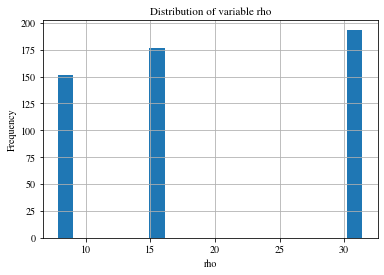

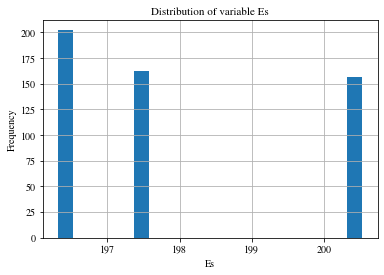

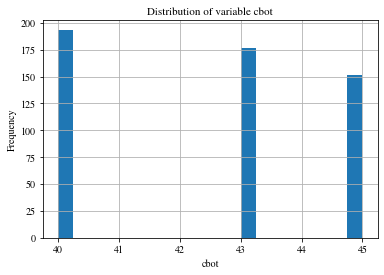

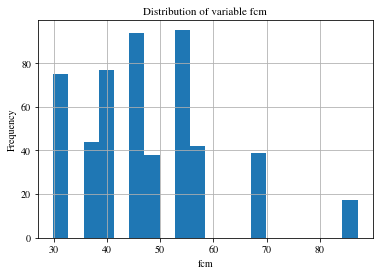

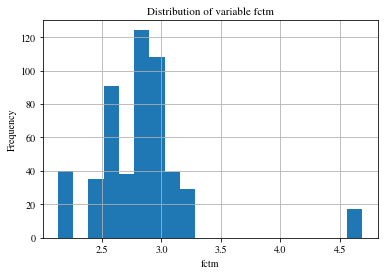

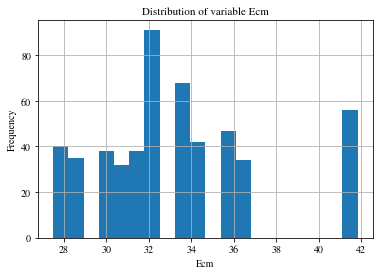

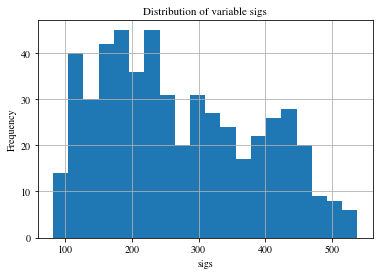

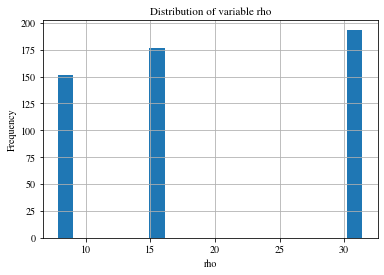

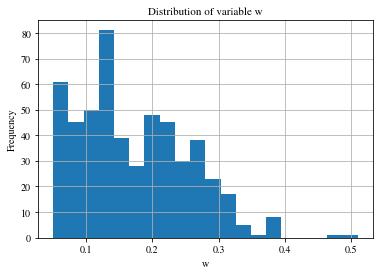

In [20]:
columns = ["rho","Es","cbot","fcm","fctm","Ecm","sigs","rho","w"];

for i in range(len(columns)):
    plotdist(trainav,20,5,25,50,75,95,columns[i]);

### Scaling and selecting the data

Scaling of data is very important to get robust predictions by the ANNs. The function "datscaleminmax" normalizes the data using a min-max scaler in the range [0,1]. Function "datbacktransform" transforms the transformed data back to the original scale.

In [21]:
def datscaleminmax(dataset):
    tempdat = dataset.values;
    min_max_scaler = preprocessing.MinMaxScaler();
    dataset_scaled = min_max_scaler.fit_transform(tempdat);
    dataset = pd.DataFrame(dataset_scaled,columns=dataset.columns);
    
    return dataset, min_max_scaler

In [22]:
def datbacktransform(dataset,temppred,min_max_scaler):
    
    if dataset.shape[1] > 1:
        tempscale=np.zeros((dataset.shape[0],dataset.shape[1]));
        tempscale[:,-1] = temppred;
        pred = min_max_scaler.inverse_transform(tempscale)[:,dataset.shape[1]-1];
    elif dataset.shape[1] == 1:
        tempscale=np.zeros((dataset.shape[0],dataset.shape[1]));
        tempscale[:,-1] = temppred;
        pred = min_max_scaler.inverse_transform(tempscale)[:,0];
    
    return pred

The EDA reveals that only $\rho$, $f_{\mathrm{cm}}$ and $\sigma_{\mathrm{s}}$ are relevant features for the description of $\hat{w}$ in the Neural Networks. Below these features are selected from the scaled training and test set.

In [23]:
trainav, sctrainav = datscaleminmax(trainav);
testav, sctestav = datscaleminmax(testav);

Xtrainav = trainav.loc[:,["rho","fcm","sigs"]];
ytrainav = trainav.loc[:,["w"]];

Xtestav = testav.loc[:,["rho","fcm","sigs"]];
ytestav = testav.loc[:,["w"]];

### Plot correlation matrix

Function "plotcorrmatrix" generates the correlation matrix of the dataset.

In [24]:
def plotcorrmatrix(dataset,figsize):
    fig = plt.figure(figsize=(figsize[0]*2, figsize[1]*2));
    sn.set(font_scale=1)
    corrmatrix = round(dataset.corr(),2);
    res = sn.heatmap(corrmatrix,annot=True,vmin=-1,vmax=1,xticklabels=["ρ",r"$E_{\mathrm{s}}$",r"$c$",r"$f_{\mathrm{cm}}$"\
        ,r"$f_{\mathrm{ctm}}$",r"$E_{\mathrm{cm}}$",r"$\sigma_{\mathrm{s}2}$",r"$\varnothing$","w"],\
              yticklabels=["ρ",r"$E_{\mathrm{s}}$",r"$c$",r"$f_{\mathrm{cm}}$"\
        ,r"$f_{\mathrm{ctm}}$",r"$E_{\mathrm{cm}}$",r"$\sigma_{\mathrm{s}2}$",r"$\varnothing$","w"]);
    res.set_xticklabels(res.get_xmajorticklabels(),fontsize=8);
    res.set_yticklabels(res.get_ymajorticklabels(),fontsize=8);
    res.set_facecolor("white");
    plt.show();
    
    return fig

The line below is commented, since the correlation plot requires the Seaborn package. Using the Matplotlib package after using the Seaborn package disturb the plots.

In [25]:
#plotcorrmat_av = plotcorrmatrix(trainav_org,figsize);

### Compute the VIF

Function "getVIF" prints the VIF values of the variables of the dataset.

In [26]:
def getVIF(dataset):
    vif = pd.DataFrame();
    vif["VIF Factor"] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])];
    vif["features"] = dataset.columns;
    print("VIF Factors");
    print(vif.round(1));
    print("\n");

In [27]:
# https://www.investopedia.com/terms/m/multicollinearity.asp
traintempav = trainav.copy(); # create a copy
traintempav.drop(["w"],axis=1,inplace=True);

# Dataset with average values of the crack widths
getVIF(Xtrainav);

VIF Factors
   VIF Factor features
0         1.5      rho
1         3.3      fcm
2         2.6     sigs




As mentioned earlier, only $\rho$, $f_{\mathrm{cm}}$ and $\sigma_{\mathrm{s2}}$ are considered. Therefore, the rest of the variables are dropped.

In [28]:
trainav.drop(["fctm","Ecm","phi","cbot","Es"],axis=1,inplace=True);
testav.drop(["fctm","Ecm","phi","cbot","Es"],axis=1,inplace=True);

In [29]:
traintempav = trainav.copy(); # create a copy
traintempav.drop(["w"],axis=1,inplace=True);

In [30]:
getVIF(traintempav);

VIF Factors
   VIF Factor features
0         1.5      rho
1         3.3      fcm
2         2.6     sigs




## 6 - Settings

Below an overview of the settings of ANNs, PIs and bootstrapping. The latter one is incorporated to make the descriptions of $\hat{w}$ and the PIs more robust.

### ANN settings

In [31]:
regparkern_PI = 1e-3; # kernel regularizer PI
regparact_PI = 1e-3; # Output regularizer PI
regparbias_PI = 1e-5; # bias regularizer PI

regparkern_mean = 1e-4; # kernel regularizer PI
regparact_mean = 1e-4; # Output regularizer PI
regparbias_mean = 1e-5; # bias regularizer PI

opt = adam_v2.Adam(learning_rate=1e-3,beta_1=0.9,beta_2=0.99,epsilon=1e-7);

nep_av = 100; bs_av = 32;

PI_nep_av = 200;

n_ = 100;
alp = 0.05;

### PI setttings

In [32]:
lambda_ = 0.002 # lambda in loss fn
alpha_ = 0.1  # capturing (1-alpha)% of samples
soften_ = 35 # Softening parameter

### Repeated K-fold cross validation settings

In [33]:
nfold = 10;
nrep = 5;

In [34]:
resav = []; # Empty array which will be added later with results of the cross-validation.

### Bootstrap settings

In [35]:
sb = 470; # Length of training set for bootstrapping 470 is approx. 90% of training set.
Nb = 20; # Number of boostrapped test sets

## 7 - Repeated K-fold cross validation

Function "Baseline_model_standard" generates the layout of the ANN, based on the chosen settings.

In [36]:
def baseline_model_standard():
    # create model
    model = Sequential();
    model.add(Dense(10, input_dim=Xtrainav.shape[1], activation=keras.layers.LeakyReLU(alpha=alp),\
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=np.sqrt(1/(Xtrainav.shape[1]))),\
                    kernel_regularizer=keras.regularizers.l1(l=regparkern_mean),\
                    activity_regularizer=keras.regularizers.l1(l=regparact_mean),\
                    bias_regularizer=keras.regularizers.l1(l=regparbias_mean)));
    model.add(Dense(1, activation='linear',\
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=np.sqrt(1/(10))),\
                    kernel_regularizer=keras.regularizers.l1(l=regparkern_mean),\
                    activity_regularizer=keras.regularizers.l1(l=regparact_mean),\
                    bias_regularizer=keras.regularizers.l1(l=regparbias_mean)));
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

Function "crossval" executes the cross validation of the ANN. It returns two scores: the Mean Square Error (MSE) and $R^2$.

In [37]:
def crossval(trainX,trainy,nep,bs):
    # evaluate model
    scorer = ["r2","neg_mean_squared_error"]; # Add as many metrics as you wish, see:
    # https://scikit-learn.org/stable/modules/model_evaluation.html

    estimators = []
    estimators.append(('standardize', preprocessing.MinMaxScaler()));
    estimators.append(('ANN',KerasRegressor(build_fn=baseline_model_standard,epochs=nep, batch_size=bs, verbose=0)));
    pipeline = Pipeline(estimators);

    kfold = KFold(n_splits=nfold,shuffle=True,random_state=42)
    results = cross_validate(pipeline, trainX, trainy, cv=kfold, scoring=scorer, return_train_score=False);
    
    return results

In [38]:
for r in range(nrep):
    resav.append(crossval(Xtrainav,ytrainav,nep_av,bs_av));
    print("Performing analysis, average dataset, repitition", r+1, "...");

Performing analysis, average dataset, repitition 1 ...
Performing analysis, average dataset, repitition 2 ...
Performing analysis, average dataset, repitition 3 ...
Performing analysis, average dataset, repitition 4 ...
Performing analysis, average dataset, repitition 5 ...


In [39]:
r2scoresav = np.zeros(nrep);
msescoresav = np.zeros(nrep);

for i in range(nrep):
    r2scoresav[i] = resav[i]["test_r2"].mean() # Average R2-score of each repitition
    msescoresav[i] = abs(resav[i]["test_neg_mean_squared_error"]).mean() # Average MSE-score of each repitition

The figure below visualises the scores of the $R^2$ (top figure) and the MSE (bottom figure), for each repitition of the simulation.

<ipython-input-40-4888633ba241>:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  axs[0].stem(range(1,nrep+1),r2scoresav,"b*",label=r"$R^2$, average dataset");
<ipython-input-40-4888633ba241>:10: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  axs[1].stem(range(1,nrep+1),msescoresav,"b*",label="MSE, average dataset");


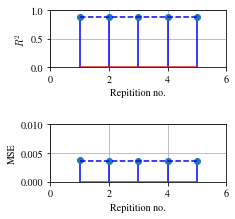

In [40]:
fig, axs = plt.subplots(2,figsize=(figsize[0],figsize[1]));
axs[0].stem(range(1,nrep+1),r2scoresav,"b*",label=r"$R^2$, average dataset");
axs[0].plot([1,nrep],[r2scoresav.mean(),r2scoresav.mean()],"b--",label=r"Averaged $R^2$,average dataset");
axs[0].grid();
axs[0].set_xlabel("Repitition no.");
axs[0].set_ylabel(r"$R^2$");
axs[0].set_xlim([0,nrep+1]);
axs[0].set_ylim([0,1]);

axs[1].stem(range(1,nrep+1),msescoresav,"b*",label="MSE, average dataset");
axs[1].plot([1,nrep],[msescoresav.mean(),msescoresav.mean()],"b--",label="Average MSE, average dataset");
axs[1].grid();
axs[1].set_xlabel("Repitition no.");
axs[1].set_ylabel("MSE");
axs[1].set_xlim([0,nrep+1]);
axs[1].set_ylim([0,0.01]);

fig.subplots_adjust(hspace=1);
plt.show();

extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted());
extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted());

In [41]:
print(r2scoresav); # Print average values of R2

[0.8807182  0.88101552 0.88429417 0.88410125 0.88546657]


In [42]:
print("Dataset with average crack values - dataset (a)");
print("Average R2-score after repeated K-fold cross validation:", round(r2scoresav.mean(),3));
print("Average MSE-score after repeated K-fold cross validation:", round(msescoresav.mean(),3));
print("\n");

Dataset with average crack values - dataset (a)
Average R2-score after repeated K-fold cross validation: 0.883
Average MSE-score after repeated K-fold cross validation: 0.004




## 8 - Bootstrapping

To make the predictions more robust, an ensemble of 20 ANNs are trained on 20 different datasets, based on randomly generated datasets from the initial training set.

In [43]:
trainavens = np.zeros((sb,trainav.shape[1],Nb));

for j in range(Nb):
    print("Bootstrapping for model no. ",j+1);
    for i in range(sb):
        k = random.randint(0,sb-1); # Generate random integer
        randrho = Xtrainav.loc[k,["rho"]];
        randfcm = Xtrainav.loc[k,["fcm"]];
        randsigs = Xtrainav.loc[k,["sigs"]];
        randw = ytrainav.loc[k,["w"]];

        trainavens[i,0,j] = randrho;
        trainavens[i,1,j] = randfcm;
        trainavens[i,2,j] = randsigs;
        trainavens[i,3,j] = randw; 

Bootstrapping for model no.  1
Bootstrapping for model no.  2
Bootstrapping for model no.  3
Bootstrapping for model no.  4
Bootstrapping for model no.  5
Bootstrapping for model no.  6
Bootstrapping for model no.  7
Bootstrapping for model no.  8
Bootstrapping for model no.  9
Bootstrapping for model no.  10
Bootstrapping for model no.  11
Bootstrapping for model no.  12
Bootstrapping for model no.  13
Bootstrapping for model no.  14
Bootstrapping for model no.  15
Bootstrapping for model no.  16
Bootstrapping for model no.  17
Bootstrapping for model no.  18
Bootstrapping for model no.  19
Bootstrapping for model no.  20


In [44]:
testav = testav.to_numpy();

Transform the scaled dataset back to the original scale.

In [45]:
mattemp = np.zeros((sb,9));
train_w_org_scale = np.zeros((sb,Nb));
for j in range(Nb):
    
    train_w_org_scale[:,j] = datbacktransform(mattemp,trainavens[:,-1,j],sctrainav);

### Deriving the Prediction Intervals (PIs) for each bootstrapped dataset

So far, the average crack width has been computed. The PIs are generated by using ANNs including LUBE (Lower Upper Bound Estimation) Method.

#### Defining the cost function

The cost function "qd_objective" is obtained from Pearce et al. The relaxed cost function is used from Pearce et al, from the article "High-quality predicition invervals for deep learning: A distribution-free, ensembled approach".

The cost function is a combination of the MPIW (Mean Prediction Interval Width) and the PICP (Prediction Interval Coverage Probability).

In [46]:
# hyperparameters

def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    #y_true = y_true[:,0]
    
    y_true = y_true;
    
    (y_u,y_l) = tf.split(y_pred,num_or_size_splits=2, axis=1);

    K_HU = tf.maximum(0.,tf.sign(y_u - y_true)) # signum function
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l)) # signum function
    K_H = tf.multiply(K_HU, K_HL) # To determine if point is inside the prediction interval; factor k
    
    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)
    
    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)**2
    
    return Loss_S

#### Defining the ANN for predicting the PIs

Function "baseline_model_PI" describes the layout of the ANN for the description of the PIs.

In [47]:
def baseline_model_PI():
    model = Sequential();
    model.add(Dense(10, input_dim=Xtrainav.shape[1], activation=keras.layers.LeakyReLU(alpha=alp),\
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=np.sqrt(1/(Xtrainav.shape[1]))),\
                    kernel_regularizer=keras.regularizers.l1(l=regparkern_PI),\
                    activity_regularizer=keras.regularizers.l1(l=regparact_PI),\
                    bias_regularizer=keras.regularizers.l1(l=regparbias_PI)));
    model.add(Dense(2, activation='linear',\
                    kernel_initializer=keras.initializers.RandomNormal(mean=0, stddev=np.sqrt(1/(10))),\
                    kernel_regularizer=keras.regularizers.l1(l=regparkern_PI),\
                    activity_regularizer=keras.regularizers.l1(l=regparact_PI),\
                    bias_initializer=keras.initializers.Constant(value=[1,0]),\
                    bias_regularizer=keras.regularizers.l1(l=regparbias_PI)));

    # compile
    model.compile(loss=qd_objective, optimizer=opt);
    
    return model

Function "ANN" compiles the ANN and predict the crack width.

In [48]:
def ANN(Xtrain,ytrain,Xtest,ytest,baseline_model,opt,lossfunc,nep,bs):
    
    model = baseline_model;
    
    model.compile(loss=lossfunc, optimizer=opt);
    
    hist = model.fit(Xtrain, ytrain, validation_data=(Xtest,ytest) , \
                              epochs=nep, batch_size=bs, verbose=0);
    
    model_sum_err = np.zeros(nep);

    for i in range(nep):
        model_sum_err[i] = hist.history['loss'][i] + hist.history['val_loss'][i];
        
    temppred = model.predict(Xtest);
    temppred_train = model.predict(Xtrain);
    
    return hist,model_sum_err,temppred,temppred_train

Function "plotcostANN" generates plots, containing training and test errors.

In [49]:
def plotcostANN(hist,model_sum_err):
    fig = plt.figure(figsize=(figsize[0],figsize[1]/2));
    plt.plot(hist.history['loss'], label='Training error'); # Training loss
    plt.plot(hist.history['val_loss'], label='Test error'); # Test loss
    plt.plot(model_sum_err,label='Total error'); # Total loss
    plt.grid();
    plt.xlabel('Epochs [-]');
    plt.ylabel('Loss');
    plt.show();
    
    return fig

#### PIs before training

Get insight in the PI before training.

In [50]:
y_pred_av = baseline_model_PI().predict(Xtestav, verbose=0);
y_u_pred_av = y_pred_av[:,0];
y_l_pred_av = y_pred_av[:,1];

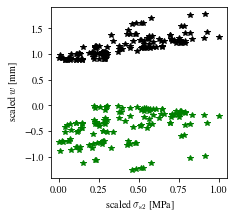

In [51]:
fig = plt.figure(figsize=(figsize[0],figsize[1]));
plt.plot(Xtestav["sigs"],y_u_pred_av,"k*"); # Upper PI
plt.plot(Xtestav["sigs"],y_l_pred_av,"g*"); # Lower PI
plt.xlabel(r" scaled $\sigma_{\mathrm{s}2}$ [MPa]");
plt.ylabel(r" scaled $w$ [mm]");

#### Train ANN and predict the PIs

Here ANNs are trained to predict PIs for each bootstrapped dataset. The figure below presents the test and training losses.

Training PIs, based on bootstrapped dataset no.  1
Training PIs, based on bootstrapped dataset no.  2
Training PIs, based on bootstrapped dataset no.  3
Training PIs, based on bootstrapped dataset no.  4
Training PIs, based on bootstrapped dataset no.  5
Training PIs, based on bootstrapped dataset no.  6
Training PIs, based on bootstrapped dataset no.  7
Training PIs, based on bootstrapped dataset no.  8
Training PIs, based on bootstrapped dataset no.  9
Training PIs, based on bootstrapped dataset no.  10
Training PIs, based on bootstrapped dataset no.  11
Training PIs, based on bootstrapped dataset no.  12
Training PIs, based on bootstrapped dataset no.  13
Training PIs, based on bootstrapped dataset no.  14
Training PIs, based on bootstrapped dataset no.  15
Training PIs, based on bootstrapped dataset no.  16
Training PIs, based on bootstrapped dataset no.  17
Training PIs, based on bootstrapped dataset no.  18
Training PIs, based on bootstrapped dataset no.  19
Training PIs, based o

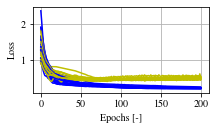

In [52]:
predavens = np.zeros((testav.shape[0],2,Nb)); # 3D array since output of ANN consist of 2 output nodes!
predavens_train = np.zeros((sb,2,Nb));
model_sum_err_av = np.zeros((PI_nep_av,Nb));

fig = plt.figure(figsize=(figsize[0],figsize[1]/2));

for i in range(Nb):
    print("Training PIs, based on bootstrapped dataset no. ",i+1);
    histav,model_sum_err_av[:,i],temppredPIav,temppredPIav_train = ANN(trainavens[:,:-1,i],trainavens[:,-1,i],testav[:,:-1],\
                                                    testav[:,-1],baseline_model_PI(),opt,qd_objective,\
                                           PI_nep_av,n_);
    
    plt.plot(histav.history['loss'],"b", label='Training error'); # Training loss
    plt.plot(histav.history['val_loss'],"y", label='Test error'); # Test loss
    
    predavens[:,:,i] = temppredPIav;
    predavens_train[:,:,i] = temppredPIav_train;
    
plt.xlabel('Epochs [-]');
plt.ylabel('Loss');
plt.grid();    
plt.show();
#fig.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Rome_2022_FiB_PhD\Figures\New\PI_Train_test_loss.tif',\
#                          bbox_inches='tight',dpi=(dpisize))

#### Extract the average value and the standard deviation; model uncertainty

The scaled PIs are transformed back to the original scale.

In [53]:
predavens_tsback = np.zeros((testav.shape[0],2,Nb));
predavens_train_tsback = np.zeros((sb,2,Nb));
for i in range(Nb):
    predavens_tsback[:,0,i] = datbacktransform(testav_org,predavens[:,0,i],sctrainav); # Scaled y_PI_u_AV
    predavens_tsback[:,1,i] = datbacktransform(testav_org,predavens[:,1,i],sctrainav); # Scaled y_PI_l_AV
    
    predavens_train_tsback[:,0,i] = datbacktransform(mattemp,predavens_train[:,0,i],sctrainav); # Scaled y_PI_u_AV
    predavens_train_tsback[:,1,i] = datbacktransform(mattemp,predavens_train[:,1,i],sctrainav); # Scaled y_PI_l_AV    

So far, the upper and lower bound of the PIs are calculated, which describes noise uncertainty. Model uncertainty can also be described, by considering the results of the predictions based on each dataset from which the standard deviation can be derived (here it is assumed that the errors are normally distributed).

In [54]:
y_PI_u_av = np.mean(predavens_tsback[:,0,:],axis=1); # Average Upper Bound PI
y_PI_l_av = np.mean(predavens_tsback[:,1,:],axis=1); # Average Lower Bound PI

y_PI_u_sig = np.std(predavens_tsback[:,0,:],axis=1); # STD Upper Bound PI
y_PI_l_sig = np.std(predavens_tsback[:,1,:],axis=1); # STD Lower Bound PIANN.res_tot_mn

y_PI_u_upper = y_PI_u_av + 1.96*y_PI_u_sig; # Upper estimate of the ensemble
y_PI_l_lower = y_PI_l_av - 1.96*y_PI_l_sig; # Lower estimate of the ensemble

Below the total error is presented.

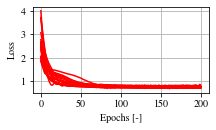

In [55]:
fig = plt.figure(figsize=(figsize[0],figsize[1]/2));

for i in range(Nb):
    plt.plot(model_sum_err_av[:,i],"r");
 
plt.xlabel('Epochs [-]');
plt.ylabel('Loss');
plt.grid();    
plt.show();

## 9 - Predict the mean

A new simulation is used to describe the average crack width. In the figure below test and training errors have been presented.

Training w_m, based on bootstrapped dataset no.  1 ...
Training w_m, based on bootstrapped dataset no.  2 ...
Training w_m, based on bootstrapped dataset no.  3 ...
Training w_m, based on bootstrapped dataset no.  4 ...
Training w_m, based on bootstrapped dataset no.  5 ...
Training w_m, based on bootstrapped dataset no.  6 ...
Training w_m, based on bootstrapped dataset no.  7 ...
Training w_m, based on bootstrapped dataset no.  8 ...
Training w_m, based on bootstrapped dataset no.  9 ...
Training w_m, based on bootstrapped dataset no.  10 ...
Training w_m, based on bootstrapped dataset no.  11 ...
Training w_m, based on bootstrapped dataset no.  12 ...
Training w_m, based on bootstrapped dataset no.  13 ...
Training w_m, based on bootstrapped dataset no.  14 ...
Training w_m, based on bootstrapped dataset no.  15 ...
Training w_m, based on bootstrapped dataset no.  16 ...
Training w_m, based on bootstrapped dataset no.  17 ...
Training w_m, based on bootstrapped dataset no.  18 ...
T

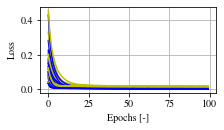

In [56]:
temppred_tot_av = np.zeros((Xtestav.shape[0],Nb));
temppred_tot_av_train = np.zeros((sb,Nb));

fig = plt.figure(figsize=(figsize[0],figsize[1]/2));

for i in range(Nb):
    print("Training w_m, based on bootstrapped dataset no. ", i+1, "...");
    hist, modelsum_tot_av, temppred, temppred_train = \
    ANN(trainavens[:,:-1,i],trainavens[:,-1,i],testav[:,:-1],\
                                                    testav[:,-1],\
        baseline_model_standard(),opt,"mean_squared_error",nep_av,bs_av);
    
    temppred_tot_av[:,i] = temppred[:,0];
    temppred_tot_av_train[:,i] = temppred_train.transpose();
    
    plt.plot(hist.history['loss'],"b", label='Training error'); # Training loss
    plt.plot(hist.history['val_loss'],"y", label='Test error'); # Test loss

plt.xlabel('Epochs [-]');
plt.ylabel('Loss');
plt.grid();    
plt.show();
#fig.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Rome_2022_FiB_PhD\Figures\New\Wav_Train_test_loss.tif',\
#                          bbox_inches='tight',dpi=(dpisize))

In [57]:
pred_tot_av_tsback = np.zeros((Xtestav.shape[0],Nb));
pred_tot_av_tsback_train = np.zeros((sb,Nb));

for i in range(Nb):
    pred_tot_av_tsback[:,i] = datbacktransform(testav_org,temppred_tot_av[:,i],sctrainav);
    pred_tot_av_tsback_train[:,i] = datbacktransform(mattemp,pred_tot_av_tsback_train[:,i],sctrainav);

In [58]:
y_mean_av = np.mean(pred_tot_av_tsback,axis=1);
y_mean_av_train = np.mean(pred_tot_av_tsback_train,axis=1);

## 10 - Plotting

To present the results of the descriptions of the ANNs, $\hat{w}$ is described as function of both $\sigma_{\mathrm{s}}$ and $w$. For plotting purposes, both values are sorted in ascending order.

### Sorting

#### Sorting, based on steel stress

In [59]:
SUMMavsig = pd.concat([testav_org.loc[:,["rho","Es","fcm","sigs","w"]].reset_index(drop=True),\
                  pd.DataFrame(y_PI_u_upper).reset_index(drop=True),pd.DataFrame(y_PI_l_lower).reset_index(drop=True),
                  pd.DataFrame(y_PI_u_av).reset_index(drop=True),pd.DataFrame(y_PI_l_av).reset_index(drop=True),
                  pd.DataFrame(y_PI_u_sig).reset_index(drop=True),pd.DataFrame(y_PI_l_sig).reset_index(drop=True),  
                  pd.DataFrame(w_kav).reset_index(drop=True),pd.DataFrame(w_mav).reset_index(drop=True),
                  pd.DataFrame(y_mean_av).reset_index(drop=True)],axis=1);
SUMMavsig.columns = ["rho","Es","fcm","sigs","w","y_PI_u_upper","y_PI_l_lower","y_PI_u_av","y_PI_l_av","y_PI_u_sig","y_PI_l_sig",\
                  "w_EC2kav","w_EC2mav","w_mean"];
SUMMavsig.sort_values(by=["sigs"],ascending=True,inplace=True);

In [60]:
trainsortsig = trainav_org;
trainsortsig.sort_values(by=["sigs"],ascending=True,inplace=True);

#### Figure (b) - Predictions for both ANN and EC2

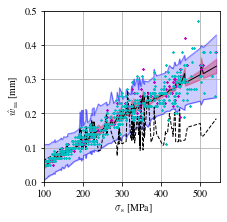

In [61]:
fig = plt.figure(figsize=(figsize[0],figsize[1]));
plt.plot(SUMMavsig["sigs"],SUMMavsig["y_PI_u_upper"],"b",alpha=0.5,linewidth=1); # Upper estimate PI
plt.plot(SUMMavsig["sigs"],SUMMavsig["y_PI_l_lower"],"b",alpha=0.5,linewidth=1); # Lower estimate PI
plt.plot(SUMMavsig["sigs"],SUMMavsig["w_mean"]-SUMMavsig["y_PI_l_sig"],"r",alpha=0.1); # Lower CI
plt.plot(SUMMavsig["sigs"],SUMMavsig["w_mean"]+SUMMavsig["y_PI_u_sig"],"r",alpha=0.1); # Upper CI
plt.fill_between(SUMMavsig["sigs"],SUMMavsig["w_mean"]+SUMMavsig["y_PI_u_sig"],SUMMavsig["w_mean"]-SUMMavsig["y_PI_l_sig"],\
                 color="r",alpha=0.3);
plt.plot(SUMMavsig["sigs"],SUMMavsig["w_mean"],"k-",linewidth=1); # Average crack width
#plt.plot(SUMMavsig["sigs"],SUMMavsig["w_EC2kav"],"k--",linewidth=1); # Characteristic crack width EC2
plt.plot(SUMMavsig["sigs"],SUMMavsig["w_EC2mav"],"k--",linewidth=1); # Average crack width EC2
plt.fill_between(SUMMavsig["sigs"],SUMMavsig["y_PI_u_upper"],SUMMavsig["y_PI_l_lower"],color="blue",alpha=0.2);
plt.plot(SUMMavsig["sigs"],SUMMavsig["w"],"m*",alpha=1,markersize=2); # Test data points
plt.plot(trainsortsig["sigs"],trainsortsig["w"],"c*",alpha=1,markersize=2); # Train data points
plt.grid();
plt.xlabel(r" $\sigma_{\mathrm{s}}$ [MPa]"); # steel stress
plt.ylabel(r" $\hat{w}_{\mathrm{m}}$ [mm]"); # crack width
plt.xlim([100,550]);
plt.ylim([0,0.5]);
plt.show();
fig.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Rome_2022_FiB_PhD\Figures\New\Line_sorted_av_sig.tif',\
                          bbox_inches='tight',dpi=(dpisize));

In [62]:
print(round(np.mean(abs(SUMMavsig["w_mean"]/SUMMavsig["w"])),3));

0.961


#### Sorting, based on crack widths from test database

In [63]:
SUMMavw = pd.concat([testav_org.loc[:,["rho","Es","fcm","sigs","w"]].reset_index(drop=True),\
                  pd.DataFrame(y_PI_u_upper).reset_index(drop=True),pd.DataFrame(y_PI_l_lower).reset_index(drop=True),
                  pd.DataFrame(y_PI_u_av).reset_index(drop=True),pd.DataFrame(y_PI_l_av).reset_index(drop=True),
                  pd.DataFrame(y_PI_u_sig).reset_index(drop=True),pd.DataFrame(y_PI_l_sig).reset_index(drop=True),  
                  pd.DataFrame(w_kav).reset_index(drop=True),pd.DataFrame(w_mav).reset_index(drop=True),
                  pd.DataFrame(y_mean_av).reset_index(drop=True)],axis=1);
SUMMavw.columns = ["rho","Es","fcm","sigs","w","y_PI_u_upper","y_PI_l_lower","y_PI_u_av","y_PI_l_av","y_PI_u_sig","y_PI_l_sig",\
                  "w_EC2kav","w_EC2mav","w_mean"];
SUMMavw.sort_values(by=["w"],ascending=True,inplace=True);

In [64]:
trainsortw = trainav_org;
trainsortw.sort_values(by=["w"],ascending=True,inplace=True);

#### Figure (a) - Predictions for both ANN and EC2

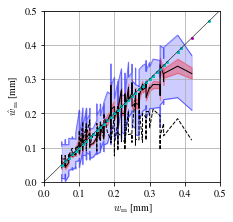

In [65]:
fig = plt.figure(figsize=(figsize[0],figsize[1]));
plt.plot(SUMMavw["w"],SUMMavw["y_PI_u_upper"],"b",alpha=0.5,linewidth=1); # Upper estimate PI
plt.plot(SUMMavw["w"],SUMMavw["y_PI_l_lower"],"b",alpha=0.5,linewidth=1); # Lower estimate PI
plt.plot(SUMMavw["w"],SUMMavw["w_mean"]-SUMMavw["y_PI_l_sig"],"r",alpha=0.1 ); # Lower CI
plt.plot(SUMMavw["w"],SUMMavw["w_mean"]+SUMMavw["y_PI_u_sig"],"r",alpha=0.1 ); # Upper CI
plt.plot(SUMMavw["w"],SUMMavw["w_mean"],"k",linewidth=1); # Average crack width
plt.plot(SUMMavw["w"],SUMMavw["w_EC2mav"],"k--",linewidth=1); # Average crack width EC2
#plt.plot(SUMMavw["w"],SUMMavw["w_EC2kav"],"k--",linewidth=1); # Characteristic crack width EC2
plt.fill_between(SUMMavw["w"],SUMMavw["y_PI_u_upper"],SUMMavw["y_PI_l_lower"],color="blue",alpha=0.2);
plt.fill_between(SUMMavw["w"],SUMMavw["w_mean"]+SUMMavw["y_PI_u_sig"],SUMMavw["w_mean"]-SUMMavw["y_PI_l_sig"],\
                 color="r",alpha=0.3);
plt.plot(SUMMavw["w"],SUMMavw["w"],"mo",alpha=1,markersize=2); # Test data points
plt.plot(trainsortw["w"],trainsortw["w"],"co",alpha=1,markersize=2); # Train data points
plt.plot([0,0.5],[0,0.5],"k",linewidth=0.5); # Ideal prediction line
plt.grid();
plt.xlabel(r" $w_{\mathrm{m}}$ [mm]"); # measured crack width
plt.ylabel(r" $\hat{w}_{\mathrm{m}}$ [mm]"); # described crack width
plt.xlim([0,0.5]);
plt.ylim([0,0.5]);
plt.show();
fig.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Rome_2022_FiB_PhD\Figures\New\Line_sorted_av_w.tif',\
                          bbox_inches='tight',dpi=(dpisize));

In [66]:
print(round(np.mean(abs(SUMMavw["w_mean"]/SUMMavw["w"])),3));

0.961


In [67]:
print(round(np.mean(abs(SUMMavw["y_PI_u_upper"]/SUMMavw["w_EC2kav"])),3));

1.076


## 11 - Compute PICP and MPIW

The last step is to calculate PICP and MPIW.

### Based on test dataset

In [68]:
count_test = np.zeros(Nb);
PICP_test = np.zeros(Nb);
MPIW_test = np.zeros(Nb);
MPIWc_test = np.zeros(Nb);

In [69]:
for j in range(Nb): # Loop over the ensemble
    
    arrtemp = np.zeros(testav_org.shape[0]);
    k = np.zeros(testav_org.shape[0]);
    comb = np.zeros(testav_org.shape[0]);
    
    for i in range(testav_org.shape[0]):
        if ((testav_org["w"].values[i] >= predavens_tsback[i,1,j]) and (testav_org["w"].values[i] <= predavens_tsback[i,0,j])):
            count_test[j] = count_test[j] + 1;
            
            k[i] = 1;
            
        else:
            
            k[i] = 0;

        arrtemp[i] = predavens_tsback[i,0,j] - predavens_tsback[i,1,j];
        
        comb[i] = arrtemp[i]*k[i]
            
    MPIW_test[j] = np.mean(arrtemp)
           
    MPIWc_test[j] = 1/count_test[j]*(np.sum(comb));
        
    PICP_test[j] = 100*count_test[j]/testav_org.shape[0];
    

    print("Test data - ANN no.",j+1,": PICP", PICP_test[j],"%, MPIW:", round(MPIW_test[j],2), "mm");
    
print("The average PICP", round(np.mean(PICP_test),2))
print("The average MPIW", round(np.mean(MPIW_test),2))
print("The average MPIWc", round(np.mean(MPIWc_test),2))

Test data - ANN no. 1 : PICP 93.12977099236642 %, MPIW: 0.08 mm
Test data - ANN no. 2 : PICP 90.07633587786259 %, MPIW: 0.08 mm
Test data - ANN no. 3 : PICP 90.83969465648855 %, MPIW: 0.08 mm
Test data - ANN no. 4 : PICP 87.78625954198473 %, MPIW: 0.08 mm
Test data - ANN no. 5 : PICP 90.83969465648855 %, MPIW: 0.09 mm
Test data - ANN no. 6 : PICP 92.36641221374046 %, MPIW: 0.09 mm
Test data - ANN no. 7 : PICP 92.36641221374046 %, MPIW: 0.08 mm
Test data - ANN no. 8 : PICP 87.78625954198473 %, MPIW: 0.08 mm
Test data - ANN no. 9 : PICP 91.6030534351145 %, MPIW: 0.09 mm
Test data - ANN no. 10 : PICP 90.07633587786259 %, MPIW: 0.09 mm
Test data - ANN no. 11 : PICP 86.25954198473282 %, MPIW: 0.09 mm
Test data - ANN no. 12 : PICP 87.02290076335878 %, MPIW: 0.08 mm
Test data - ANN no. 13 : PICP 90.07633587786259 %, MPIW: 0.08 mm
Test data - ANN no. 14 : PICP 91.6030534351145 %, MPIW: 0.09 mm
Test data - ANN no. 15 : PICP 89.31297709923665 %, MPIW: 0.09 mm
Test data - ANN no. 16 : PICP 90.839

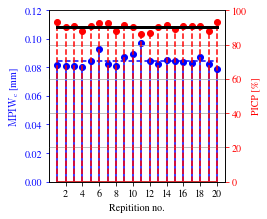

In [70]:
fig, ax1 = plt.subplots(1,figsize=(figsize[0],figsize[1]));

#ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape_like(ax1)

# ==========================
# Subplot 1
ax1.set_xlabel('Repitition no.');
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
ax1.tick_params(axis='y', colors='b') ;
ax1.set_ylabel(r"$\mathrm{MPIW}_{\mathrm{c}}$ [mm]",color="b") ;
ax1.stem(range(1,Nb+1), MPIWc_test,markerfmt="bo",linefmt="b") ;
ax1.plot([1,Nb],[MPIWc_test.mean(),MPIWc_test.mean()],"b--",label=r"Averaged MPIW");
ax1.tick_params(axis ='y',color="b") ;
plt.ylim([0,0.12])

ax2 = ax1.twinx() 
ax2.set_ylabel('PICP [%]',color="r") ;
ax2.tick_params(axis='y', colors='r') ;
ax2.stem(range(1,Nb+1), PICP_test,markerfmt="ro",linefmt="r--");
ax2.plot([1,Nb],[PICP_test.mean(),PICP_test.mean()],"r--",label=r"Averaged PICP"); # Computed average PICP

ax2.plot([1,Nb],[(1-alpha_)*100,(1-alpha_)*100],"k",linewidth=3,label=r"Target PICP"); # Target PICP
ax2.tick_params(axis ='y');
plt.ylim([0,100]);
plt.grid();

fig.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Rome_2022_FiB_PhD\Figures\New\PICP_MPIW_test.tif',\
                          bbox_inches='tight',dpi=(dpisize));

The figure above represents the PICP and MPIW for the test sets. Indeed, the average value of the PICP is indeed very close to the target value of the PICP (90%).

### Based on training dataset

For each training dataset is the PICP and MPIW calculated.

In [71]:
count_train = np.zeros(Nb);
PICP_train = np.zeros(Nb);
MPIW_train = np.zeros(Nb);
MPIWc_train = np.zeros(Nb);

In [72]:
for j in range(Nb): # Loop over the ensemble
    
    arrtemp = np.zeros(sb);
    k = np.zeros(sb);
    comb = np.zeros(sb);
    
    for i in range(sb):
        if ((train_w_org_scale[i,j] >= predavens_train_tsback[i,1,j]) and (train_w_org_scale[i,j] <= predavens_train_tsback[i,0,j])):
            count_train[j] = count_train[j] + 1;
            
            k[i] = 1;
        
        else:
            k[i] = 0;

        arrtemp[i] = predavens_train_tsback[i,0,j] - predavens_train_tsback[i,1,j];
        
        comb[i] = arrtemp[i]*k[i]
        
    MPIW_train[j] = np.mean(arrtemp);
    
    MPIWc_train[j] = 1/count_train[j]*(np.sum(comb));
            
    PICP_train[j] = 100*count_train[j]/sb

    print("Train data - ANN no.",j+1,": PICP", PICP_train[j],"%, MPIW:", round(MPIW_train[j],2), "mm");
    
print("The average PICP", round(np.mean(PICP_train),2))
print("The average MPIW", round(np.mean(MPIW_train),2))
print("The average MPIWc", round(np.mean(MPIWc_train),2))

Train data - ANN no. 1 : PICP 91.48936170212765 %, MPIW: 0.08 mm
Train data - ANN no. 2 : PICP 93.19148936170212 %, MPIW: 0.08 mm
Train data - ANN no. 3 : PICP 92.34042553191489 %, MPIW: 0.08 mm
Train data - ANN no. 4 : PICP 94.25531914893617 %, MPIW: 0.08 mm
Train data - ANN no. 5 : PICP 93.40425531914893 %, MPIW: 0.09 mm
Train data - ANN no. 6 : PICP 91.06382978723404 %, MPIW: 0.09 mm
Train data - ANN no. 7 : PICP 93.61702127659575 %, MPIW: 0.08 mm
Train data - ANN no. 8 : PICP 93.19148936170212 %, MPIW: 0.08 mm
Train data - ANN no. 9 : PICP 91.48936170212765 %, MPIW: 0.09 mm
Train data - ANN no. 10 : PICP 91.48936170212765 %, MPIW: 0.09 mm
Train data - ANN no. 11 : PICP 87.23404255319149 %, MPIW: 0.09 mm
Train data - ANN no. 12 : PICP 91.91489361702128 %, MPIW: 0.08 mm
Train data - ANN no. 13 : PICP 92.12765957446808 %, MPIW: 0.08 mm
Train data - ANN no. 14 : PICP 91.91489361702128 %, MPIW: 0.08 mm
Train data - ANN no. 15 : PICP 91.70212765957447 %, MPIW: 0.08 mm
Train data - ANN no

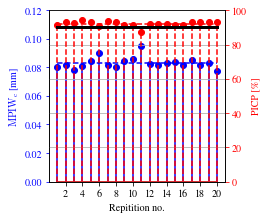

In [73]:
fig, ax1 = plt.subplots(1,figsize=(figsize[0],figsize[1]));

ax1.set_xlabel('Repitition no.');
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(2))
ax1.tick_params(axis='y', colors='b') ;
ax1.set_ylabel(r"$\mathrm{MPIW}_{\mathrm{c}}$ [mm]",color="b") ;
ax1.stem(range(1,Nb+1), MPIWc_train,markerfmt="bo",linefmt="b") ;
ax1.plot([1,Nb],[MPIWc_train.mean(),MPIWc_train.mean()],"b--",label=r"Averaged MPIW");
ax1.tick_params(axis ='y',color="b") ;
plt.ylim([0,0.12])

ax2 = ax1.twinx() 
ax2.set_ylabel('PICP [%]',color="r") ;
ax2.tick_params(axis='y', colors='r') ;
ax2.stem(range(1,Nb+1), PICP_train,markerfmt="ro",linefmt="r--");
ax2.plot([1,Nb],[PICP_train.mean(),PICP_train.mean()],"r--",label=r"Averaged PICP"); # Computed average PICP

ax2.plot([1,Nb],[(1-alpha_)*100,(1-alpha_)*100],"k",linewidth=3,label=r"Target PICP"); # Target PICP
ax2.tick_params(axis ='y');
plt.ylim([0,100]);
plt.grid();

fig.savefig(r'C:\Users\20210065\surfdrive\Documents\60_Publications\Rome_2022_FiB_PhD\Figures\New\PICP_MPIW_train.tif',\
                          bbox_inches='tight',dpi=(dpisize));

The figure above represents the PICP and MPIW for the training sets. Indeed, the average value of the PICP is indeed very close to the target value of the PICP (90%).

### Scoring

In [74]:
# input: y_true, y_pred

r2scoresavboot = np.zeros(Nb);
msescoresavboot = np.zeros(Nb);

for i in range(Nb):
    r2scoresavboot[i] = r2_score(testav_org["w"],pred_tot_av_tsback[:,i]);
    msescoresavboot[i] = mean_squared_error(testav_org["w"],pred_tot_av_tsback[:,i]);
    
    print("R2-score bootstrapped dataset", i+1, "equals", r2scoresavboot[i]);
    print("MSE bootstrapped dataset", i+1, "equals", msescoresavboot[i]);    

R2-score bootstrapped dataset 1 equals 0.8942034049592169
MSE bootstrapped dataset 1 equals 0.0007294348794304784
R2-score bootstrapped dataset 2 equals 0.9128116949087743
MSE bootstrapped dataset 2 equals 0.0006011364617873554
R2-score bootstrapped dataset 3 equals 0.9205232374353225
MSE bootstrapped dataset 3 equals 0.0005479677554513217
R2-score bootstrapped dataset 4 equals 0.8834211788616049
MSE bootstrapped dataset 4 equals 0.0008037750015343325
R2-score bootstrapped dataset 5 equals 0.9126778377930538
MSE bootstrapped dataset 5 equals 0.0006020593652988424
R2-score bootstrapped dataset 6 equals 0.9191935940432323
MSE bootstrapped dataset 6 equals 0.0005571352363803717
R2-score bootstrapped dataset 7 equals 0.9086918214261914
MSE bootstrapped dataset 7 equals 0.0006295417182691752
R2-score bootstrapped dataset 8 equals 0.9162433892477624
MSE bootstrapped dataset 8 equals 0.0005774759881640117
R2-score bootstrapped dataset 9 equals 0.92015730386924
MSE bootstrapped dataset 9 equal

<ipython-input-75-e00aa18ff3de>:3: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  axs[0].stem(range(1,Nb+1),r2scoresavboot,"b*",label=r"$R^2$, average dataset");
<ipython-input-75-e00aa18ff3de>:13: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  axs[1].stem(range(1,Nb+1),msescoresavboot,"b*",label="MSE, average dataset");


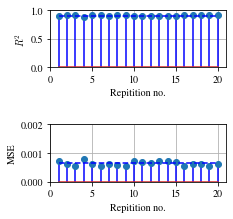

In [75]:
fig, axs = plt.subplots(2,figsize=(figsize[0],figsize[1]));
#axs[0].set_title(r"Repeated K-fold cross validation, $R^2$");
axs[0].stem(range(1,Nb+1),r2scoresavboot,"b*",label=r"$R^2$, average dataset");
#axs[0].stem(range(1,nrep+1),r2scoresin,"g*",label=r"$R^2$, individual dataset");
axs[0].plot([1,Nb],[r2scoresavboot.mean(),r2scoresavboot.mean()],"b--",label=r"Averaged $R^2$,average dataset");
#axs[0].plot([1,nrep],[r2scoresin.mean(),r2scoresin.mean()],"g--",label=r"Averaged $R^2$,individual dataset");
axs[0].grid();
axs[0].set_xlabel("Repitition no.");
axs[0].set_ylabel(r"$R^2$");
axs[0].set_xlim([0,Nb+1]);
axs[0].set_ylim([0,1]);

axs[1].stem(range(1,Nb+1),msescoresavboot,"b*",label="MSE, average dataset");
axs[1].plot([1,Nb],[msescoresavboot.mean(),msescoresavboot.mean()],"b--",label="Average MSE, average dataset");
axs[1].grid();
axs[1].set_xlabel("Repitition no.");
axs[1].set_ylabel("MSE");
axs[1].set_xlim([0,Nb+1]);
axs[1].set_ylim([0,0.002]);

fig.subplots_adjust(hspace=1);
plt.show();

The figure above represents an overview of the values $R^2$ and MSE of all the individual simulations.

In [76]:
# Average R2-score and MSE ANN prediction:
print("Print average R2-score",round(np.mean(r2scoresavboot),3));
print("Print average MSE-score",round(np.mean(msescoresavboot),3));

Print average R2-score 0.908
Print average MSE-score 0.001
